# Clustering Software Architecture Papers

This notebook uses the Software Architecture dataset to cluster papers using their titles and abstracts. The clustering is done using [hierarchical clustering](https://en.wikipedia.org/wiki/Hierarchical_clustering) and the [TF-IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) algorithm is used to extract the most important words from each cluster.

In [35]:
import os

base_dir = os.path.join('..', '..')
data_dir = os.path.join(base_dir, 'data')

input_file = os.path.join(data_dir, 'software_architecture', 'bib-text_embeddings.csv')

reports_dir = os.path.join(base_dir, 'reports', 'unsupervised-classification')
os.makedirs(reports_dir, exist_ok=True)

cluster_output = os.path.join(reports_dir, 'software_architecture_classify.csv')
cluster_names_file = os.path.join(reports_dir, 'software_architecture_classify.txt')

In [36]:
import pandas as pd
import numpy as np

df = pd.read_csv(input_file)
df["text"] = df["title"] + " " + df["abstract"]
df["embedding"] = df.embedding.apply(eval).apply(np.array)  # convert string to array

df.head()

,author,title,abstract,doi,classes,url,embedding,text
0,Alessio Bucaioni and Patrizio Pelliccione and ...,Aligning Architecture with Business Goals in t...,When designing complex automotive systems in p...,10.1109/ICSA51549.2021.00020,"Meta Data{Research Level{Primary Research}, Ki...",https://doi.org/10.1109/ICSA51549.2021.00020,"[0.00024948068312369287, -0.00626408914104104,...",Aligning Architecture with Business Goals in t...
1,H{\'{e}}ctor Cadavid and Vasilios Andrikopoulo...,System- and Software-level Architecting Harmon...,The problems caused by the gap between system-...,10.1109/ICSA51549.2021.00010,"Meta Data{Kind{full}, Paper class{Evaluation R...",https://doi.org/10.1109/ICSA51549.2021.00010,"[0.01373602356761694, -0.007272415794432163, 0...",System- and Software-level Architecting Harmon...
2,Joshua Garcia and Mehdi Mirakhorli and Lu Xiao...,Constructing a Shared Infrastructure for Softw...,Over the past three decades software engineeri...,10.1109/ICSA51549.2021.00022,"Meta Data{Paper class{Evaluation Research}, Re...",https://doi.org/10.1109/ICSA51549.2021.00022,"[0.0021983531769365072, -0.0010011119302362204...",Constructing a Shared Infrastructure for Softw...
3,Holger Knoche and Wilhelm Hasselbring,Continuous {API} Evolution in Heterogenous Ent...,The ability to independently deploy parts of a...,10.1109/ICSA51549.2021.00014,"Meta Data{Research Level{Primary Research}, Ki...",https://doi.org/10.1109/ICSA51549.2021.00014,"[0.0058586616069078445, -0.031336553394794464,...",Continuous {API} Evolution in Heterogenous Ent...
4,Duc Minh Le and Suhrid Karthik and Marcelo Sch...,Architectural Decay as Predictor of Issue- and...,Architectural decay imposes real costs in term...,10.1109/ICSA51549.2021.00017,"Meta Data{Paper class{Evaluation Research}, Re...",https://doi.org/10.1109/ICSA51549.2021.00017,"[0.01517355814576149, -0.02274669148027897, 0....",Architectural Decay as Predictor of Issue- and...


In [37]:
# Use hierarchical clustering to cluster the papers
from sklearn.cluster import AgglomerativeClustering

hierarchical_cluster = AgglomerativeClustering(
    n_clusters=6,
    metric='cosine',
    linkage='complete',  # Provides the best dispersion
)

predictions = hierarchical_cluster.fit_predict(df.embedding.tolist())

In [38]:
df["cluster"] = predictions
df.to_csv(cluster_output, index=False)

Number of papers in each cluster:
Counter({0: 82, 1: 30, 3: 26, 2: 10, 5: 3, 4: 2})


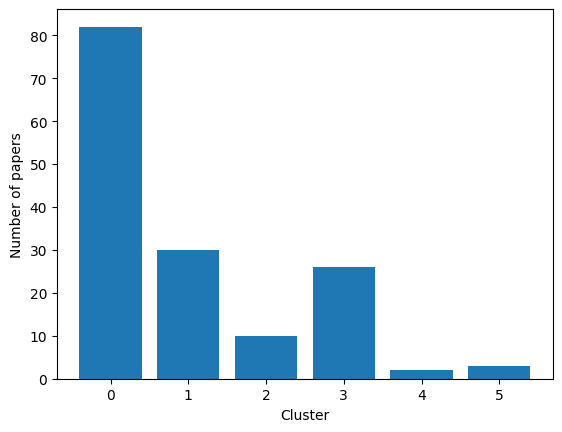

In [39]:
from collections import Counter

# Print the number of papers in each cluster
print("Number of papers in each cluster:")
print(Counter(predictions))

# Plot the number of papers in each cluster
import matplotlib.pyplot as plt

plt.bar(Counter(predictions).keys(), Counter(predictions).values())
plt.xlabel("Cluster")
plt.ylabel("Number of papers")
plt.show()

In [40]:
# Add the cluster predictions to the dataframe
df[["title", "cluster"]]

,title,cluster
0,Aligning Architecture with Business Goals in t...,3
1,System- and Software-level Architecting Harmon...,0
2,Constructing a Shared Infrastructure for Softw...,0
3,Continuous {API} Evolution in Heterogenous Ent...,0
4,Architectural Decay as Predictor of Issue- and...,0
...,...,...
148,Trace {Link} {Recovery} for {Software} {Archit...,0
149,Updating {Service}-{Based} {Software} {Systems...,0
150,Data-Centric Communication and Containerizatio...,3
151,Towards a Reference Architecture for Cloud-Bas...,0


In [41]:
# Group by prediction and join the text
cluster_group = df.groupby('cluster')['text'].apply(' '.join).reset_index()

In [42]:
import nltk

nltk.download('punkt')

[nltk_data] Downloading package punkt to /Users/patrick/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Create a stemmer instance
stemmer = PorterStemmer()

nltk.download('stopwords')
stop_words = stopwords.words('english')
stop_words.extend(['thi', 'the', 'use'])
stop_words.sort()

# Tokenize the text
cluster_group['text'] = cluster_group['text'].apply(nltk.word_tokenize)

# Convert the text to lowercase
cluster_group['text'] = cluster_group['text'].apply(lambda x: [item.lower() for item in x])

# Remove punctuation from the text
cluster_group['text'] = cluster_group['text'].apply(lambda x: [item for item in x if item not in string.punctuation])

# Remove numbers from the text
cluster_group['text'] = cluster_group['text'].apply(lambda x: [item for item in x if item.isalpha()])

# Remove words less than 2 characters
cluster_group['text'] = cluster_group['text'].apply(lambda x: [item for item in x if len(item) > 2])

# Stem the words
# cluster_group['text'] = cluster_group['text'].apply(lambda x: [stemmer.stem(item) for item in x])

# Remove all stop words
cluster_group['text'] = cluster_group['text'].apply(lambda x: [item for item in x if item not in stop_words])

# Join the words back into a string
cluster_group['text'] = cluster_group['text'].apply(lambda x: ' '.join(x))

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/patrick/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [44]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Create an instance of TfidfVectorizer
vectorizer = TfidfVectorizer()

# Fit and transform the documents
tfidf_matrix = vectorizer.fit_transform(cluster_group['text'])

# Get the feature names (terms)
feature_names = vectorizer.get_feature_names_out()

cluster_words = []

# Display the most significant word for each document
# Print 6 most important words for each document
for inx in range(len(cluster_group['text'])):
    words = tfidf_matrix[inx].nonzero()[1][tfidf_matrix[inx].data.argsort()[-6:][::-1]]
    # words.sort()

    cluster = f"Cluster {inx:02d}: {', '.join(feature_names[words])}"
    print(cluster)
    cluster_words.append(cluster)

Cluster 00: software, architectural, architecture, design, approach, systems
Cluster 01: microservice, microservices, software, architecture, systems, approach
Cluster 02: blockchain, design, digital, brokers, graphql, architecture
Cluster 03: systems, iot, approach, learning, architecture, automotive
Cluster 04: handling, exception, checkpoint, erosion, hadoop, design
Cluster 05: clustering, weights, optimized, architecture, microservice, systems


In [45]:
import openai

response = openai.ChatCompletion.create(
    model="gpt-3.5-turbo",
    temperature=0.0,
    messages=[
        {
            "role": "user",
            "content": "Name these clusters:\n" + "\n".join(cluster_words)
        }
    ]
)
print(response.choices[0].message.content)

with open(cluster_names_file, 'w') as file:
    file.write("\n".join(cluster_words))
    file.write("\n\n")
    file.write(response.choices[0].message.content)

Cluster 00: Software Architecture and Design
Cluster 01: Microservices Architecture
Cluster 02: Blockchain and Digital Design
Cluster 03: IoT and Automotive Architecture
Cluster 04: Exception Handling and Hadoop Design
Cluster 05: Clustering and Optimization in Architecture
